In [1]:
# use OOT data to estimate bkg in signal region

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
def keyToyear(key):
    for year in years:
        if year in key:
            return year

# Load ntuples

In [3]:
fpath =OrderedDict()
tree = OrderedDict()
mass = [15, 40, 55]
# mass = [15]
# VBFH = 0
# decay = 'dddd'

# mass = [7, 15, 40, 55]
# VBFH=1
# decay = 'bbbb'



prod = 'ggH'
# prod = 'ttH'
# prod = 'VBFH'
# decay = 'dddd' #no vbfh generated
# decay = '4Tau'
decay = 'bbbb'

mass = [15, 40, 55]
if not decay == 'bbbb': mass = [7, 15, 40, 55]
# mass = [15]
# ctau = [1, 10, 100, 1000, 10000, 100000]
# ctau = [10, 100, 1000, 10000, 100000]
OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

years = ['Summer16', 'Fall17', 'Fall18']
lumi = {
    'Summer16': 35.92 * 1000,
    'Fall17': 41.53 * 1000,
    'Fall18': 59.74 * 1000,
}
category = 0
ntupler_version = 'V1p17/'
analyzer_version = 'v1/v86/'


# for y in years:
#         mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_'+y+'/'+analyzer_version+'/normalized/'
#         tune = 'TuneCP5'
#         if y == 'Summer16': tune = 'TuneCUETP8M1'
#         for m in mass:
#                 for ct in OLD_CTAU:
#                         key = 'MC_'+y+'_ggH_'+str(m)+'_'+str(ct)                       
#                         fpath[key] = mc_path+'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_' + tune + '_13TeV-powheg-pythia8_1pb_weighted.root'
#                         if VBFH:
#                             key = 'MC_'+y+'_VBFH_'+str(m)+'_'+str(ct) 
#                             if decay == 'bbbb':
#                                 fpath[key] = mc_path+'VBFH_HToSSTo4b_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_' + tune + '_13TeV-powheg-pythia8_1pb_weighted.root'
#                             else:
#                                 fpath[key] = mc_path+'VBFH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_' + tune + '_13TeV-powheg-pythia8_1pb_weighted.root'

if prod == 'ggH' or prod == 'VBFH':
    mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
    key = prod
    fpath[key] = mc_path+prod+'_HToSSTobbbb_MH-125.root'
#     for m in mass:
#         for ct in OLD_CTAU:
#             key = 'MC_'+prod+'_'+str(m)+'_'+str(ct)                       
#             fpath[key] = mc_path+prod+'_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_137000pb_weighted.root'
else:
    mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
    key = prod
    fpath[key] = mc_path+prod+'ToSS_SToBB.root'
    if key == 'ttH': fpath[key] = mc_path+prod+'_HToSS_SToBB.root'
#     for m in mass:
#         for ct in OLD_CTAU:
#             key = 'MC_'+prod+'_'+str(m)+'_'+str(ct)                       
#             fpath[key] = mc_path+prod+'ToSS_SToBB_ms'+str(m)+'_pl'+str(ct)+'_137000pb_weighted.root'
#             print(fpath[key])

fpath['ggZH']= '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v90/normalized/ggZHToSS_SToBB_ms40_pl1000_137000pb_weighted.root'
NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():

    root_dir = uproot.open(v) 
    
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    w = tree[k]["weight"].array()


# nCsc with different hit vetoing

In [5]:
%%time

start_t = time.time()
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50
cut_based = True
cut_based_version = 'v4'
# BDT_CUT = 0.467 #90% wp vBDT/v1, bdt_flatten_noEvtSelection
# bdtBkgEff =  0.0661076084960519

# BDT_CUT = 0.9227871 #90% wp vBDT/v2, bdt_flatten_metfilter_me1112nohits_eta2p1
# # bdtBkgEff =  0.10278372591006424
# if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
#     BDT_CUT = 0.92245656 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs
#     bdtBkgEff = 0.09957173447537473
# elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi':
#     BDT_CUT = 0.9608465 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
#     bdtBkgEff = 0.06745182012847965
# elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2':
#     BDT_CUT = 0.76344216 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
#     bdtBkgEff = 0.051208285385500575
# elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v5':
#     BDT_CUT = 0.7802247 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
#     bdtBkgEff = 0.061027837259100645

# elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12':
#     BDT_CUT = 0.50882477 
#     bdtBkgEff = 0.18136439267886856
# elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2':
#     BDT_CUT = 0.2983932 
#     bdtBkgEff = 0.34527687296416937
#     BDT_BINS = [0.0, BDT_CUT]
# #     BDT_BINS = [0.0, 0.1, 0.2, BDT_CUT]


# else:
#     print('BDT NAME NOT FOUND')
intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}
higgsPtWeight = {}
gHiggsEta = {}
cscRechitClusterEta = {}
cscRechitClusterNStation10  = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterEta_JESDown = {}
cscRechitClusterNStation10_JESDown  = {}
cscRechitClusterAvgStation10_JESDown = {}
cscRechitClusterEta_JESUp = {}
cscRechitClusterNStation10_JESUp  = {}
cscRechitClusterAvgStation10_JESUp = {}

dphiMet_cluster_JESUp= {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESUp= {}
dphiMet_cluster_JESDown= {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESDown= {}
cscRechitClusterMet_dPhi = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
nCscRings = {}
nDtRings = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_selJESUp = {}
bdt_selJESDown = {}
bdt_sel = {}


higgsPtWeightSys = {}
sf_facScaleUp = {}
sf_facScaleDown = {}
sf_renScaleUp = {}
sf_renScaleDown = {}
sf_facRenScaleUp = {}
sf_facRenScaleDown = {}
pileupWeightUp = {}
pileupWeightDown = {}
sel_evJESUp = {}
sel_evJESDown = {}
weight_JESUp = {}
weight_JESDown = {}
weight_JES  = {}
cluster_index = '3'
for k,T in tree.items():
########### SELECTION: CLUSTERS ############
    
    sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0
    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))


    print(np.count_nonzero(sel_rechitcluster.flatten()))

########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )
    sel_jetUp = np.logical_and(T.array('jetPtJESUp') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )
    sel_jetDown = np.logical_and(T.array('jetPtJESDown') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )



########### SELECTION: EVENTS ############

    sel_ev[k] = np.logical_and(T.array('METNoMuTrigger'),T.array('met') >= 200)
    sel_evJESUp[k] = np.logical_and(T.array('METNoMuTrigger') ,T.array('metJESUp') >= 200)
    sel_evJESDown[k] = np.logical_and(T.array('METNoMuTrigger') ,T.array('metJESDown') >= 200)
    
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_evJESUp[k] = np.logical_and(sel_evJESUp[k] ,sel_jetUp.sum()>=1)
    sel_evJESDown[k] = np.logical_and(sel_evJESDown[k] ,sel_jetDown.sum()>=1)
    for i,v in enumerate([sel_ev[k],sel_evJESUp[k],sel_evJESDown[k]]):
        v  = np.logical_and(v, T.array('category') == category)
        v = np.logical_and(v ,T.array('nLeptons') == 0)
        v  = np.logical_and(v,sel_rechitcluster.sum() == 1)
        v = np.logical_and(v, (T.array('nDtRings')+T.array('nCscRings'))<10)
        v = np.logical_and(v,T.array('Flag2_all'))
        v = np.logical_and(v, np.sum(T.array('gLLP_csc'),axis = 1) > 0)
        if i == 0:sel_ev[k] = v
        elif i == 1: sel_evJESUp[k] = v
        else: sel_evJESDown[k] = v
    
    if np.count_nonzero(sel_ev[k])>0:print(np.count_nonzero(sel_evJESUp[k])/np.count_nonzero(sel_ev[k]),np.count_nonzero(sel_evJESDown[k])/np.count_nonzero(sel_ev[k]))
    ########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]
    
    ##### bdt variables ####
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
   
    cscRechitClusterNStation10_JESUp[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_evJESUp[k]][:,0].flatten()
    cscRechitClusterEta_JESUp[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_evJESUp[k]][:,0].flatten()
    cscRechitClusterAvgStation10_JESUp[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_evJESUp[k]][:,0].flatten()
    
    cscRechitClusterNStation10_JESDown[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_evJESDown[k]][:,0].flatten()
    cscRechitClusterEta_JESDown[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_evJESDown[k]][:,0].flatten()
    cscRechitClusterAvgStation10_JESDown[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_evJESDown[k]][:,0].flatten()

    if cut_based:     
        print("cut based", cut_based_version)
        if cut_based_version == 'v4':
            cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
            cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
            cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
            cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
            cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
            bdt_sel[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
            
            cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10_JESUp[k])==2, np.abs(cscRechitClusterEta_JESUp[k]) < 1.6)
            cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10_JESUp[k])==3, np.abs(cscRechitClusterEta_JESUp[k]) < 1.6)
            cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10_JESUp[k])==4, np.abs(cscRechitClusterEta_JESUp[k]) < 1.8)
            cond1 = np.logical_and(cscRechitClusterNStation10_JESUp[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10_JESUp[k])==1, cond2), np.logical_or(cond3, cond4)))
            cond2 = np.logical_and(cscRechitClusterNStation10_JESUp[k] > 1, np.abs(cscRechitClusterEta_JESUp[k]) < 1.9)
            bdt_selJESUp[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
            
            cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10_JESDown[k])==2, np.abs(cscRechitClusterEta_JESDown[k]) < 1.6)
            cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10_JESDown[k])==3, np.abs(cscRechitClusterEta_JESDown[k]) < 1.6)
            cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10_JESDown[k])==4, np.abs(cscRechitClusterEta_JESDown[k]) < 1.8)
            cond1 = np.logical_and(cscRechitClusterNStation10_JESDown[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10_JESDown[k])==1, cond2), np.logical_or(cond3, cond4)))
            cond2 = np.logical_and(cscRechitClusterNStation10_JESDown[k] > 1, np.abs(cscRechitClusterEta_JESDown[k]) < 1.9)
            bdt_selJESDown[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
            
            
        else:
            print("CUT BASED ERROR")

    else:
        print('ERROR')
        
    if len(bdt_sel[k])>0:print("effiency",np.count_nonzero(bdt_sel[k])/len(bdt_sel[k]))
    jetMet_dPhiMin30[k] = T.array('jetMet_dPhiMin')[sel_ev[k]][bdt_sel[k]]

    weight[k] = (T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev[k]][bdt_sel[k]]
    if prod == 'ggH' :weight[k] = weight[k] *T.array('higgsPtWeight')[sel_ev[k]][bdt_sel[k]]

    npv[k] = T.array('npv')[sel_ev[k]]
    pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][bdt_sel[k]]
    pileupWeightUp[k] = T.array('pileupWeightUp')[sel_ev[k]][bdt_sel[k]]
    pileupWeightDown[k] = T.array('pileupWeightDown')[sel_ev[k]][bdt_sel[k]]
    higgsPtWeight[k] = T.array('higgsPtWeight')[sel_ev[k]][bdt_sel[k]]
    if prod == 'ggH':
        sf_facScaleUp[k] = T.array('sf_facScaleUp')[sel_ev[k]][bdt_sel[k]]
        sf_facScaleDown[k] = T.array('sf_facScaleDown')[sel_ev[k]][bdt_sel[k]]
        sf_renScaleUp[k] = T.array('sf_renScaleUp')[sel_ev[k]][bdt_sel[k]]
        sf_renScaleDown[k] = T.array('sf_renScaleDown')[sel_ev[k]][bdt_sel[k]]
        sf_facRenScaleUp[k] = T.array('sf_facRenScaleUp')[sel_ev[k]][bdt_sel[k]]
        sf_facRenScaleDown[k] = T.array('sf_facRenScaleDown')[sel_ev[k]][bdt_sel[k]]
    else:
        sf_facScaleUp[k] =T.array('scaleWeights')[sel_ev[k]][bdt_sel[k]][:,1]
        sf_facScaleDown[k] = T.array('scaleWeights')[sel_ev[k]][bdt_sel[k]][:,2]
        sf_renScaleUp[k] =T.array('scaleWeights')[sel_ev[k]][bdt_sel[k]][:,3]
        sf_renScaleDown[k] = T.array('scaleWeights')[sel_ev[k]][bdt_sel[k]][:,6]
        sf_facRenScaleUp[k] = T.array('scaleWeights')[sel_ev[k]][bdt_sel[k]][:,4]
        sf_facRenScaleDown[k] = T.array('scaleWeights')[sel_ev[k]][bdt_sel[k]][:,8]
    higgsPtWeightSys[k] = T.array('higgsPtWeightSys')[sel_ev[k]][bdt_sel[k]]
    gHiggsEta[k] = T.array('gHiggsEta')[sel_ev[k]]


    
    dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()[bdt_sel[k]]
    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]][:,0].flatten()[bdt_sel[k]]
    
    dphiMet_cluster_JESUp[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi'))[sel_rechitcluster][sel_evJESUp[k]][:,0].flatten()[bdt_selJESUp[k]]
    nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESUp[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_evJESUp[k]][:,0].flatten()[bdt_selJESUp[k]]
    
    dphiMet_cluster_JESDown[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi'))[sel_rechitcluster][sel_evJESDown[k]][:,0].flatten()[bdt_selJESDown[k]]
    nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESDown[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_evJESDown[k]][:,0].flatten()[bdt_selJESDown[k]]
    
    
    weight_JESUp[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF')*T.array('metJESUpSF'))[sel_evJESUp[k]][bdt_selJESUp[k]]
    weight_JESDown[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF')*T.array('metJESDownSF'))[sel_evJESDown[k]][bdt_selJESDown[k]]
    weight_JES[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev[k]][bdt_sel[k]]






16347
0.9988156336360048 0.9595341492301619
cut based v4
effiency 0.8989998684037374
465
1.0 0.9517684887459807
cut based v4
effiency 0.9228295819935691
CPU times: user 1.4 s, sys: 45.6 ms, total: 1.45 s
Wall time: 2.15 s


4.0814924


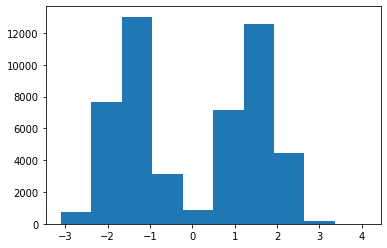

In [17]:
plt.hist( T.array('gHiggsEta'))
print(np.max(np.abs(T.array('gHiggsEta'))))

# JEC

In [11]:

#have to use v53, without met cut
ctaus = [ '100', '1000','10000','100000' ]

N_RECHIT_CUT = 130
DPHI_CUT = 0.75
var = dphiMet_cluster
binA =0
binB = 0
binC = 0
binD = 0
binAUp = 0
binADown = 0
binBUp = 0
binBDown = 0
binCUp = 0
binCDown =0 
binDUp = 0
binDDown = 0
for m in mass:
    for ct in ctaus:   
        prod = 'ggH'
        k = 'MC_'+prod+'_'+str(m)+'_'+str(ct)
        k = 'ggH'
        if np.count_nonzero(sel_ev[k]) == 0: continue
        w = weight_JES[k]
        wUp = weight_JESUp[k]
        wDown = weight_JESDown[k]
        a = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, dphiMet_cluster[k]>=DPHI_CUT)
        b = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, dphiMet_cluster[k]>=DPHI_CUT)
        c = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, dphiMet_cluster[k]<DPHI_CUT)
        d = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, dphiMet_cluster[k]<DPHI_CUT)
        
        aUp = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESUp[k]>=N_RECHIT_CUT, dphiMet_cluster_JESUp[k]>=DPHI_CUT)
        bUp = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESUp[k]<N_RECHIT_CUT, dphiMet_cluster_JESUp[k]>=DPHI_CUT)
        cUp = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESUp[k]<N_RECHIT_CUT, dphiMet_cluster_JESUp[k]<DPHI_CUT)
        dUp = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESUp[k]>=N_RECHIT_CUT, dphiMet_cluster_JESUp[k]<DPHI_CUT)

        aDown = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESDown[k]>=N_RECHIT_CUT, dphiMet_cluster_JESDown[k]>=DPHI_CUT)
        bDown = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESDown[k]<N_RECHIT_CUT, dphiMet_cluster_JESDown[k]>=DPHI_CUT)
        cDown = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESDown[k]<N_RECHIT_CUT, dphiMet_cluster_JESDown[k]<DPHI_CUT)
        dDown = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto_JESDown[k]>=N_RECHIT_CUT, dphiMet_cluster_JESDown[k]<DPHI_CUT)
        
        binAUp += np.sum(wUp[aUp])
        binADown += np.sum(wDown[aDown])
        binBUp += np.sum(wUp[bUp])
        binBDown += np.sum(wDown[bDown])
        binCUp += np.sum(wUp[cUp])
        binCDown +=np.sum(wDown[cDown])
        binDUp += np.sum(wUp[dUp])
        binDDown += np.sum(wDown[dDown])
        binA +=np.sum(w[a])
        binB += np.sum(w[b])
        binC +=np.sum(w[c])
        binD +=np.sum(w[d])
        print(k, round(max(np.sum(wUp[aUp])/np.sum(w[a])-1,abs(np.sum(wDown[aDown])/np.sum(w[a])-1)),4), 
              round(max(np.sum(wUp[bUp])/np.sum(w[b])-1,abs(np.sum(wDown[bDown])/np.sum(w[b])-1)),4),
              round(max(np.sum(wUp[cUp])/np.sum(w[c])-1,abs(np.sum(wDown[cDown])/np.sum(w[c])-1)),4),
              round(max(np.sum(wUp[dUp])/np.sum(w[d])-1,abs(np.sum(wDown[dDown])/np.sum(w[d])-1)),4),)
#         print(np.sum(w[a]**2)**0.5/np.sum(w[a]), np.sum(w[a]**2)**0.5/np.sum(w[b]), 
#              np.sum(w[a]**2)**0.5/np.sum(w[c]), np.sum(w[a]**2)**0.5/np.sum(w[d]), )
              


print(abs(binAUp/binA-1),abs(binADown/binA-1))
print(abs(binBUp/binB-1),abs(binBDown/binB-1))
print(abs(binCUp/binC-1),abs(binCDown/binC-1))
print(abs(binDUp/binD-1),abs(binDDown/binD-1))








ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
ggH 0.0863 0.0895 0.0422 0.0424
0.000690507965128706 0.08626240893900039
0.001970823682392542 0.08954328043542181
0.0014356525636882722 0.04218678092277528
0.00161005590708041 0.04244687693925031


### higgs pt reweight signal change

In [12]:
ctaus = [ '100', '1000','10000','100000' ]


BR = 0.01
N_RECHIT_CUT = 130
DPHI_CUT = 0.75
var = dphiMet_cluster
binAUp = 0
binADown = 0
binBUp = 0
binBDown = 0
binCUp = 0
binCDown =0 
binDUp = 0
binDDown = 0
for m in mass:
    signal_rate = []
    signal_rateUp = []
    signal_rateDown = []
    mc_stat_unc = []
    for ct in ctaus:   
        signal = 0
        signalUp = 0
        signalDown = 0
        mc_stat = 0
        k = 'MC_ggH_'+str(m)+'_'+str(ct)
        if np.count_nonzero(sel_ev[k]) == 0: continue
        w = weight[k]/higgsPtWeight[k]
        wUp = weight[k]               

        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]<DPHI_CUT)
        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]<DPHI_CUT)
        cond  = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0


        signalUp += np.sum(wUp[cond])
        signal_rate.append(np.sum(w[cond]))
        signal_rateUp.append(np.sum(wUp[cond]))

    signal_rate = np.array(signal_rate)
    signal_rateUp = np.array(signal_rateUp)
    print(m, 'GeV & ', '\% & '.join(map(str, [round(num,2) for num in np.abs(signal_rateUp/signal_rate-1)*100])),'\%\\\\',)



15 GeV &  5.11\% & 1.48\% & 2.47\% & 0.65 \%\\
40 GeV &  7.28\% & 0.84\% & 2.18\% & 4.28 \%\\
55 GeV &  4.22\% & 2.9\% & 3.13 \%\\


# pileup uncertainty

In [8]:
ctaus = [ '100', '1000','10000','100000' ]

N_RECHIT_CUT = 130
DPHI_CUT = 0.75
var = dphiMet_cluster
binA =0
binB = 0
binC = 0
binD = 0
binA_unc =0
binB_unc = 0
binC_unc = 0
binD_unc = 0

binAUp = 0
binADown = 0
binBUp = 0
binBDown = 0
binCUp = 0
binCDown =0 
binDUp = 0
binDDown = 0
for m in mass:
    for ct in ctaus:   
        prod = 'ggH'
        k = 'MC_'+prod+'_'+str(m)+'_'+str(ct)
        if np.count_nonzero(sel_ev[k]) == 0: continue
        w = weight[k]
        wUp = w * pileupWeightUp[k]
        wDown = w * pileupWeightDown[k]
        a = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]>=DPHI_CUT)
        b = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]>=DPHI_CUT)
        c = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]<DPHI_CUT)
        d = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]<DPHI_CUT)
        binAUp += np.sum(wUp[a])
        binADown += np.sum(wDown[a])
        binBUp += np.sum(wUp[b])
        binBDown += np.sum(wDown[b])
        binCUp += np.sum(wUp[c])
        binCDown +=np.sum(wDown[c])
        binDUp += np.sum(wUp[d])
        binDDown += np.sum(wDown[d])
        binA +=np.sum(w[a])
        binB += np.sum(w[b])
        binC +=np.sum(w[c])
        binD +=np.sum(w[d])

        binA_unc +=np.sum(w[a]**2)
        binB_unc += np.sum(w[b]**2)
        binC_unc +=np.sum(w[c]**2)
        binD_unc +=np.sum(w[d]**2)
binA_unc = binA_unc**0.5
binB_unc = binB_unc**0.5
binC_unc = binC_unc**0.5
binD_unc = binD_unc**0.5


print(abs(binAUp/binA-1),'\t', abs(binADown/binA-1))
print(abs(binBUp/binB-1),'\t',abs(binBDown/binB-1))
print(abs(binCUp/binC-1),'\t',abs(binCDown/binC-1))
print(abs(binDUp/binD-1),'\t',abs(binDDown/binD-1))


print(abs(binA_unc/binA))
print(abs(binB_unc/binB))
print(abs(binC_unc/binC))
print(abs(binD_unc/binD))




0.008481025278348042 	 0.008292072585672772
0.009297486478113015 	 0.011424247295641843
0.0095640989236907 	 0.010975506384580225
0.010719881168607892 	 0.010364397626409394
0.046285478568198306
0.06915768784867975
0.025976740818643866
0.010741282833747874


# higgs pt reweight uncertainty

In [8]:
ctaus = [ '100', '1000','10000','100000' ]
#use v55
signal_rate = []
signal_rateUp = []
signal_rateDown = []
BR = 0.01
N_RECHIT_CUT = 130
DPHI_CUT = 0.75
var = dphiMet_cluster
facScaleUp= {'a':0,'c':0,'b':0,'d':0}
facScaleDown= {'a':0,'c':0,'b':0,'d':0}
renScaleUp= {'a':0,'c':0,'b':0,'d':0}
renScaleDown= {'a':0,'c':0,'b':0,'d':0}
facRenScaleUp= {'a':0,'c':0,'b':0,'d':0}
facRenScaleDown = {'a':0,'c':0,'b':0,'d':0}
signal = {'a':0,'c':0,'b':0,'d':0} 
cond = {}
for m in mass:
    for ct in ctaus:   
        k = 'MC_'+prod+'_'+str(m)+'_'+str(ct)
        k = prod
        k='ggH'
        if np.count_nonzero(sel_ev[k]) == 0: continue
        w = weight[k]
        cond['a'] = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]>=DPHI_CUT)
        cond['b'] = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]>=DPHI_CUT)
        cond['c'] = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var[k]<DPHI_CUT)
        cond['d'] = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var[k]<DPHI_CUT)
        for b in cond:
            facScaleUp[b] += np.sum((w*sf_facScaleUp[k])[cond[b]])
            facScaleDown[b] += np.sum((w*sf_facScaleDown[k])[cond[b]]) 
            renScaleUp[b] += np.sum((w*sf_renScaleUp[k])[cond[b]])
            renScaleDown[b] += np.sum((w*sf_renScaleDown[k])[cond[b]])
            facRenScaleUp[b] += np.sum((w*sf_facRenScaleUp[k])[cond[b]])
            facRenScaleDown[b] += np.sum((w*sf_facRenScaleDown[k])[cond[b]])
            signal[b] += np.sum(w[cond[b]])
#             print(ct, m,k, ((np.sum((w*sf_facScaleUp[k])[cond[b]])/np.sum(w[cond[b]])-1)**2+(np.sum((w*sf_renScaleUp[k])[cond[b]])/np.sum(w[cond[b]])-1)**2+(np.sum((w*sf_facRenScaleUp[k])[cond[b]])/np.sum(w[cond[b]])-1)**2)**0.5,
#             ((np.sum((w*sf_facScaleDown[k])[cond[b]])/np.sum(w[cond[b]])-1)**2+( np.sum((w*sf_renScaleDown[k])[cond[b]])/np.sum(w[cond[b]])-1)**2+(np.sum((w*sf_facRenScaleDown[k])[cond[b]])/np.sum(w[cond[b]])-1)**2)**0.5)
for b in cond:
    print(((facScaleUp[b]/signal[b]-1)**2+(renScaleUp[b]/signal[b]-1)**2+(facRenScaleUp[b]/signal[b]-1)**2)**0.5,
    ((facScaleDown[b]/signal[b]-1)**2+(renScaleDown[b]/signal[b]-1)**2+(facRenScaleDown[b]/signal[b]-1)**2)**0.5)
#     print(abs(facScaleUp[b]/signal[b]-1), abs(facScaleDown[b]/signal[b]-1), abs(renScaleUp[b]/signal[b]-1), abs(renScaleDown[b]/signal[b]-1), abs(facRenScaleUp[b]/signal[b]-1),abs(facRenScaleDown[b]/signal[b]-1))

0.13331579259510948 0.20484488806285014
0.1333979817152841 0.205244040319055
0.13416553091477068 0.2074985511614766
0.13430464625916322 0.20805103925520932


# reweight of clustering/cut-based uncertainty from 130 and 250 Nhits

In [13]:
for m in mass:
    distribution = []
    for ct in OLD_CTAU:
        k = 'MC_ggH_'+str(m)+'_'+str(ct)
        if np.count_nonzero(sel_ev[k]) == 0: continue
        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=130, nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<250)
        Nrechits130= np.sum((pileupWeight[k] * weight[k] * higgsPtWeight[k])[cond])
        cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=250
        Nrechits250= np.sum((pileupWeight[k] * weight[k] * higgsPtWeight[k])[cond])
#         print(k,Nrechits130+Nrechits250)
        distribution.append(Nrechits130/(Nrechits130+Nrechits250))
    print(','.join(map(str,distribution)))

0.31378287,0.4888003,0.5769335,0.58579075
0.2510649,0.4398903,0.5063633,0.5096977
0.21306165,0.34659937,0.45667982,0.47577354
nan,0.33487955,0.41113272,0.35920176


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in float_scalars
  # This is added back by InteractiveShellApp.init_path()
